# Aplicação do modelo SOM para detecção de anomalias contextuais

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from minisom import MiniSom
%matplotlib inline

# Será utilizada a codificação One-Hot-Encoder para variáveis categóricas
encoder = OneHotEncoder()

pd.set_option('display.max_columns', None)
df = pd.read_csv('sigesguarda_outlier.csv')
df_pop = pd.read_csv('populacao_estimada_curitiba.csv')
df.head(10)

,dataHora,data,ano,mes,mesNome,semana,dia,diaSemana,tipoDia,horario,hora,periodoDia,bairro,regiao,ocorrencia
0,2009-01-01 15:22:00,2009-01-01,2009,1,janeiro,s1,1,quinta,dia útil,15:22:00,15,tarde,fazendinha,fazendinha portão,roubo
1,2009-01-01 14:20:00,2009-01-01,2009,1,janeiro,s1,1,quinta,dia útil,14:20:00,14,tarde,centro,matriz,roubo
2,2009-01-02 00:58:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,00:58:00,0,madrugada,capão raso,pinheirinho,roubo
3,2009-01-02 00:21:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,00:21:00,0,madrugada,novo mundo,fazendinha portão,dano
4,2009-01-02 12:40:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,12:40:00,12,tarde,centro,matriz,roubo
5,2009-01-02 14:05:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,14:05:00,14,tarde,barreirinha,boa vista,dano
6,2009-01-05 15:25:00,2009-01-05,2009,1,janeiro,s1,5,segunda,dia útil,15:25:00,15,tarde,cidade industrial,cic,roubo
7,2009-01-02 15:00:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,15:00:00,15,tarde,centro,matriz,furto
8,2009-01-02 15:15:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,15:15:00,15,tarde,santa felicidade,santa felicidade,dano
9,2009-01-02 21:25:00,2009-01-02,2009,1,janeiro,s1,2,sexta,dia útil,21:25:00,21,noite,cajuru,cajuru,dano


## Preparação adicional para a utilização no modelo SOM

In [37]:
# Agrupa as colunas utilizando o data frame preparado anteriormente
df_group = df.groupby(['ano', 'mesNome', 'semana', 'tipoDia', 'periodoDia', 'regiao', 'ocorrencia']).size().reset_index(name='count')
df_group

,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count
0,2009,abril,s1,dia útil,madrugada,boa vista,dano,1
1,2009,abril,s1,dia útil,madrugada,cic,dano,1
2,2009,abril,s1,dia útil,madrugada,matriz,agressão física/verbal,1
3,2009,abril,s1,dia útil,madrugada,matriz,dano,2
4,2009,abril,s1,dia útil,madrugada,matriz,porte ilegal,1
...,...,...,...,...,...,...,...,...
51737,2022,setembro,s4,fim de semana,noite,fazendinha portão,violação de medida protetiva lei maria da penha,1
51738,2022,setembro,s4,fim de semana,noite,pinheirinho,roubo,1
51739,2022,setembro,s4,fim de semana,tarde,cic,agressão física/verbal,2
51740,2022,setembro,s4,fim de semana,tarde,pinheirinho,crime ambiental,1


In [38]:
# Adiciona o valor normalizado da contagem por grupo dividido pelo valor da população estimada daquele ano
df_pop = df_pop[['ano', 'populacao_estimada']]
df_group = pd.merge(df_group, df_pop, on='ano', how='inner')
df_group['count_por_pop'] = df_group['count'] / df_group['populacao_estimada']
df_group

,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop
0,2009,abril,s1,dia útil,madrugada,boa vista,dano,1,1851215,5.401858e-07
1,2009,abril,s1,dia útil,madrugada,cic,dano,1,1851215,5.401858e-07
2,2009,abril,s1,dia útil,madrugada,matriz,agressão física/verbal,1,1851215,5.401858e-07
3,2009,abril,s1,dia útil,madrugada,matriz,dano,2,1851215,1.080372e-06
4,2009,abril,s1,dia útil,madrugada,matriz,porte ilegal,1,1851215,5.401858e-07
...,...,...,...,...,...,...,...,...,...,...
51737,2022,setembro,s4,fim de semana,noite,fazendinha portão,violação de medida protetiva lei maria da penha,1,1963726,5.092360e-07
51738,2022,setembro,s4,fim de semana,noite,pinheirinho,roubo,1,1963726,5.092360e-07
51739,2022,setembro,s4,fim de semana,tarde,cic,agressão física/verbal,2,1963726,1.018472e-06
51740,2022,setembro,s4,fim de semana,tarde,pinheirinho,crime ambiental,1,1963726,5.092360e-07


## Codificação das colunas categóricas utilizando a codificação One-Hot-Encoder

Este processo cria novas colunas binárias para cada categoria de uma coluna categórica
É necessário para vetorizar os dados com valores numéricos a fim de ser utilizado no SOM

In [39]:
# Realiza a codificação da coluna categórica relativa ao mês do ano utilizando o One-Hot-Encoder
encoded_column = encoder.fit_transform(df_group[['mesNome']]).toarray()
category_names = encoder.get_feature_names(['mesNome'])
df_encoded = pd.concat([df_group, pd.DataFrame(encoded_column, columns=category_names)], axis=1)
df_encoded

C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop,mesNome_abril,mesNome_agosto,mesNome_dezembro,mesNome_fevereiro,mesNome_janeiro,mesNome_julho,mesNome_junho,mesNome_maio,mesNome_março,mesNome_novembro,mesNome_outubro,mesNome_setembro
0,2009,abril,s1,dia útil,madrugada,boa vista,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,abril,s1,dia útil,madrugada,cic,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009,abril,s1,dia útil,madrugada,matriz,agressão física/verbal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009,abril,s1,dia útil,madrugada,matriz,dano,2,1851215,1.080372e-06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009,abril,s1,dia útil,madrugada,matriz,porte ilegal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51737,2022,setembro,s4,fim de semana,noite,fazendinha portão,violação de medida protetiva lei maria da penha,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51738,2022,setembro,s4,fim de semana,noite,pinheirinho,roubo,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51739,2022,setembro,s4,fim de semana,tarde,cic,agressão física/verbal,2,1963726,1.018472e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51740,2022,setembro,s4,fim de semana,tarde,pinheirinho,crime ambiental,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
# Realiza a codificação da coluna categórica relativa a semana do mes utilizando o One-Hot-Encoder
encoded_column = encoder.fit_transform(df_group[['semana']]).toarray()
category_names = encoder.get_feature_names(['semana'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)
df_encoded

C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop,mesNome_abril,mesNome_agosto,mesNome_dezembro,mesNome_fevereiro,mesNome_janeiro,mesNome_julho,mesNome_junho,mesNome_maio,mesNome_março,mesNome_novembro,mesNome_outubro,mesNome_setembro,semana_s1,semana_s2,semana_s3,semana_s4
0,2009,abril,s1,dia útil,madrugada,boa vista,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2009,abril,s1,dia útil,madrugada,cic,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2009,abril,s1,dia útil,madrugada,matriz,agressão física/verbal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2009,abril,s1,dia útil,madrugada,matriz,dano,2,1851215,1.080372e-06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2009,abril,s1,dia útil,madrugada,matriz,porte ilegal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51737,2022,setembro,s4,fim de semana,noite,fazendinha portão,violação de medida protetiva lei maria da penha,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
51738,2022,setembro,s4,fim de semana,noite,pinheirinho,roubo,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
51739,2022,setembro,s4,fim de semana,tarde,cic,agressão física/verbal,2,1963726,1.018472e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
51740,2022,setembro,s4,fim de semana,tarde,pinheirinho,crime ambiental,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
# Realiza a codificação das demais colunas categóricas utilizando o One-Hot-Encoder
# Este processo cria uma nova coluna com um valor binário para cada categoria da coluna. 
# Necessário para o treinamento do modelo SOM

encoded_column = encoder.fit_transform(df_group[['tipoDia']]).toarray()
category_names = encoder.get_feature_names(['tipoDia'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)

encoded_column = encoder.fit_transform(df_group[['periodoDia']]).toarray()
category_names = encoder.get_feature_names(['periodoDia'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)

encoded_column = encoder.fit_transform(df_group[['regiao']]).toarray()
category_names = encoder.get_feature_names(['regiao'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)

encoded_column = encoder.fit_transform(df_group[['ocorrencia']]).toarray()
category_names = encoder.get_feature_names(['ocorrencia'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)

encoded_column = encoder.fit_transform(df_group[['ano']]).toarray()
category_names = encoder.get_feature_names(['ano'])
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_column, columns=category_names)], axis=1)

# Realiza a normalização da contagem de ocorrências utilizando a normalização min max
df_encoded['countNorm'] = (df_encoded['count_por_pop'] - df_encoded['count_por_pop'].min()) / (df_encoded['count_por_pop'].max() - df_encoded['count_por_pop'].min())
df_encoded

C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\breno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_fe

,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop,mesNome_abril,mesNome_agosto,mesNome_dezembro,mesNome_fevereiro,mesNome_janeiro,mesNome_julho,mesNome_junho,mesNome_maio,mesNome_março,mesNome_novembro,mesNome_outubro,mesNome_setembro,semana_s1,semana_s2,semana_s3,semana_s4,tipoDia_dia útil,tipoDia_fim de semana,periodoDia_madrugada,periodoDia_manhã,periodoDia_noite,periodoDia_tarde,regiao_bairro novo,regiao_boa vista,regiao_boqueirão,regiao_cajuru,regiao_cic,regiao_fazendinha portão,regiao_matriz,regiao_pinheirinho,regiao_santa felicidade,ocorrencia_agressão física/verbal,ocorrencia_crime ambiental,ocorrencia_dano,ocorrencia_estupro,ocorrencia_furto,ocorrencia_homicídio,ocorrencia_maus tratos a animais,ocorrencia_porte ilegal,ocorrencia_roubo,ocorrencia_seqüestro e cárcere privado,ocorrencia_violação de medida protetiva lei maria da penha,ano_2009,ano_2010,ano_2011,ano_2012,ano_2013,ano_2014,ano_2015,ano_2016,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,countNorm
0,2009,abril,s1,dia útil,madrugada,boa vista,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
1,2009,abril,s1,dia útil,madrugada,cic,dano,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
2,2009,abril,s1,dia útil,madrugada,matriz,agressão física/verbal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
3,2009,abril,s1,dia útil,madrugada,matriz,dano,2,1851215,1.080372e-06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055408
4,2009,abril,s1,dia útil,madrugada,matriz,porte ilegal,1,1851215,5.401858e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51737,2022,setembro,s4,fim de semana,noite,fazendinha portão,violação de medida protetiva lei maria da penha,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
51738,2022,setembro,s4,fim de semana,noite,pinheirinho,roubo,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
51739,2022,setembro,s4,fim de semana,tarde,cic,agressão física/verbal,2,1963726,1.018472e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.049403
51740,2022,setembro,s4,fim de semana,tarde,pinheirinho,crime ambiental,1,1963726,5.092360e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [42]:
# Cria um novo dataframe apenas com as colunas codificadas anteriormente
# Este processo vetoriza numericamente as instâncias e permite sua utilização no modelo SOM
df_final = df_encoded.drop('ano', axis=1)
df_final = df_final.drop('mesNome', axis=1)
df_final = df_final.drop('semana', axis=1)
df_final = df_final.drop('tipoDia', axis=1)
df_final = df_final.drop('periodoDia', axis=1)
df_final = df_final.drop('regiao', axis=1)
df_final = df_final.drop('ocorrencia', axis=1)
df_final = df_final.drop('count', axis=1)
df_final = df_final.drop('count_por_pop', axis=1)
df_final = df_final.drop('populacao_estimada', axis=1)
df_final

,mesNome_abril,mesNome_agosto,mesNome_dezembro,mesNome_fevereiro,mesNome_janeiro,mesNome_julho,mesNome_junho,mesNome_maio,mesNome_março,mesNome_novembro,mesNome_outubro,mesNome_setembro,semana_s1,semana_s2,semana_s3,semana_s4,tipoDia_dia útil,tipoDia_fim de semana,periodoDia_madrugada,periodoDia_manhã,periodoDia_noite,periodoDia_tarde,regiao_bairro novo,regiao_boa vista,regiao_boqueirão,regiao_cajuru,regiao_cic,regiao_fazendinha portão,regiao_matriz,regiao_pinheirinho,regiao_santa felicidade,ocorrencia_agressão física/verbal,ocorrencia_crime ambiental,ocorrencia_dano,ocorrencia_estupro,ocorrencia_furto,ocorrencia_homicídio,ocorrencia_maus tratos a animais,ocorrencia_porte ilegal,ocorrencia_roubo,ocorrencia_seqüestro e cárcere privado,ocorrencia_violação de medida protetiva lei maria da penha,ano_2009,ano_2010,ano_2011,ano_2012,ano_2013,ano_2014,ano_2015,ano_2016,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,countNorm
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055408
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
51738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
51739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.049403
51740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


## Treinamento do modelo SOM

In [43]:
# Cria um mapa com dimensões 115 x 115
grid_rows = 115
grid_cols = 115

# Número de iterações do treinamento
n_iterations = 100000

# Taxa de aprendizado, quando menor, menos os neurônios irão se movimentar a cada iteração
learning_rate = 0.1

input_size = df_final.shape[1]

# Inicialização do modelo SOM utilizando os parâmetros determinados anteriormente
som = MiniSom(grid_rows, grid_cols, input_size, sigma=3, learning_rate=learning_rate, neighborhood_function='triangle', random_seed=2)

# Treinamento do SOM utilizando os dados preparados anteriormente
som.train(df_final.values, n_iterations, random_order=False, verbose=True)

# Cria um novo dataframe que irá conter os resultados do SOM
results_df = pd.DataFrame(df_final.copy())

# A partir dos resultados encontrados, cria novas colunas para cada instância indicando:
# BMU -> best match unit que indica o neurônio mais próximo da instância
# BMU_Weights ->  indica o valor dos pessos do neurônio, utilizado para o cálculo da distância
# distancia -> distância entre a instância e o seu BMU
results_df['BMU'] = results_df.apply(lambda row: som.winner(row.values), axis=1)
results_df['BMU_weights'] = results_df['BMU'].apply(lambda bmu: som.get_weights()[bmu[0], bmu[1]])
results_df['distancia'] = results_df.apply(lambda row: np.linalg.norm(row.values[:57] - row['BMU_weights']), axis=1)

results_df

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 1.457982640820436


,mesNome_abril,mesNome_agosto,mesNome_dezembro,mesNome_fevereiro,mesNome_janeiro,mesNome_julho,mesNome_junho,mesNome_maio,mesNome_março,mesNome_novembro,mesNome_outubro,mesNome_setembro,semana_s1,semana_s2,semana_s3,semana_s4,tipoDia_dia útil,tipoDia_fim de semana,periodoDia_madrugada,periodoDia_manhã,periodoDia_noite,periodoDia_tarde,regiao_bairro novo,regiao_boa vista,regiao_boqueirão,regiao_cajuru,regiao_cic,regiao_fazendinha portão,regiao_matriz,regiao_pinheirinho,regiao_santa felicidade,ocorrencia_agressão física/verbal,ocorrencia_crime ambiental,ocorrencia_dano,ocorrencia_estupro,ocorrencia_furto,ocorrencia_homicídio,ocorrencia_maus tratos a animais,ocorrencia_porte ilegal,ocorrencia_roubo,ocorrencia_seqüestro e cárcere privado,ocorrencia_violação de medida protetiva lei maria da penha,ano_2009,ano_2010,ano_2011,ano_2012,ano_2013,ano_2014,ano_2015,ano_2016,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,countNorm,BMU,BMU_weights,distancia
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,"(109, 103)","[0.3953070547074122, 0.08074513404226091, 0.06...",1.969305
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,"(109, 103)","[0.3953070547074122, 0.08074513404226091, 0.06...",1.959569
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,"(34, 64)","[0.11711492094728404, 0.1494713806684032, 0.01...",2.069907
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055408,"(109, 103)","[0.3953070547074122, 0.08074513404226091, 0.06...",1.915792
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003003,"(57, 87)","[0.04730925089772466, 0.047924986782560415, 0....",2.104114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,"(45, 29)","[0.0005629697225368355, 0.11919998824622616, 0...",1.278658
51738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,"(66, 45)","[0.0033192470115859926, 6.202941212911481e-10,...",1.511223
51739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.049403,"(47, 81)","[0.015223477237226914, 6.124312921059173e-05, ...",1.224514
51740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,"(43, 28)","[0.07803462780622789, 0.0281919405637289, 4.16...",1.672406


Os resultados indicam um erro de quantização de 1.46.
O erro de quantização indica a distância entre os dados reais e os resutlados encontrados pelo modelo. Quanto menor, mais próximo dos resultados reais.
A primeira aplicação do modelo apresentou um erro de quantização de 2.4; e a partir de diversos treinamentos foi possível reduzir o erro para 1.46

In [44]:
# Encontra-se um threshold que representa 1% das instâncias que tem a maior distância em relação a seus BMUs
# Quanto maior a distância, mais possível de serem outliers
threshold = np.quantile(results_df['distancia'], 0.99)
threshold

1.9592752348346332

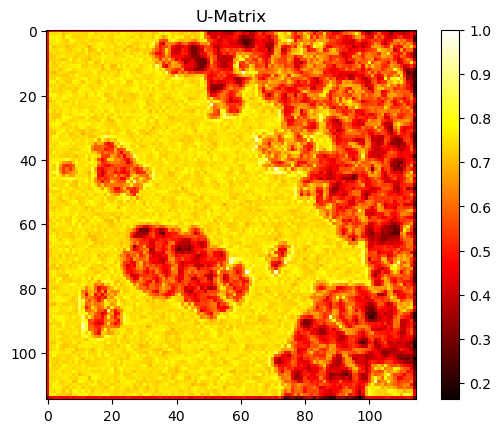

In [45]:
# Plotagem de uma U-Matrix que indica a topografia dos resultados encontrados
# Cada pixel representa um BMU.
# Valores mais escuros indicam áreas com alta densidade, ou seja, onde há uma quantidade maior de instâncias associadas com o BMU
# De modo contrário, áreas mais claras indicam áreas com baixa densidade, ou seja, com BMUS com poucas associações

# Cria-se um novo dataframe contendo os valores originais das instâncias e os resultados encontrados pelo SOM
df_group['distancia'] = results_df['distancia']
df_group['BMU'] = results_df['BMU']
df_group['BMUX'] = df_group.apply(lambda row: row['BMU'][0], axis=1)
df_group['BMUY'] = df_group.apply(lambda row: row['BMU'][1], axis=1)

df_bmu = df_group.groupby(['BMUX', 'BMUY']).size().reset_index(name='count')

u_matrix = som.distance_map()
plt.imshow(u_matrix, cmap='hot')
plt.title('U-Matrix')
plt.colorbar()

In [46]:
df_group['distancia'].describe()

count    51742.000000
mean         1.457983
std          0.232746
min          0.254060
25%          1.310441
50%          1.450042
75%          1.624177
max          2.209826
Name: distancia, dtype: float64

In [47]:
# Ordena o data frame pela distância em ordem descendente
df_sorted = df_group.sort_values('distancia', ascending=False)
df_sorted

,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop,distancia,BMU,BMUX,BMUY
17188,2014,janeiro,s1,dia útil,madrugada,boa vista,porte ilegal,1,1864416,5.363610e-07,2.209826,"(58, 87)",58,87
1238,2009,julho,s1,fim de semana,manhã,boqueirão,homicídio,1,1851215,5.401858e-07,2.182123,"(9, 84)",9,84
29214,2017,fevereiro,s1,dia útil,madrugada,boqueirão,crime ambiental,1,1908359,5.240104e-07,2.177895,"(109, 105)",109,105
9308,2012,dezembro,s1,dia útil,madrugada,cic,agressão física/verbal,1,1776761,5.628219e-07,2.177065,"(34, 64)",34,64
17196,2014,janeiro,s1,dia útil,manhã,fazendinha portão,estupro,1,1864416,5.363610e-07,2.175951,"(108, 107)",108,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2630,2009,outubro,s4,fim de semana,noite,santa felicidade,dano,1,1851215,5.401858e-07,0.340509,"(87, 102)",87,102
5277,2010,outubro,s3,fim de semana,tarde,santa felicidade,dano,1,1851215,5.401858e-07,0.338087,"(35, 106)",35,106
2639,2009,outubro,s4,fim de semana,tarde,santa felicidade,roubo,1,1851215,5.401858e-07,0.322512,"(97, 103)",97,103
2777,2009,setembro,s3,dia útil,tarde,santa felicidade,dano,3,1851215,1.620557e-06,0.308854,"(102, 113)",102,113


In [48]:
# Isola-se as istâncias onde sua distância com o BMU é maior que o threshold, indicando uma possível anomalia
df_outliers = df_sorted[df_sorted['distancia'] >= threshold]
df_outliers

,ano,mesNome,semana,tipoDia,periodoDia,regiao,ocorrencia,count,populacao_estimada,count_por_pop,distancia,BMU,BMUX,BMUY
17188,2014,janeiro,s1,dia útil,madrugada,boa vista,porte ilegal,1,1864416,5.363610e-07,2.209826,"(58, 87)",58,87
1238,2009,julho,s1,fim de semana,manhã,boqueirão,homicídio,1,1851215,5.401858e-07,2.182123,"(9, 84)",9,84
29214,2017,fevereiro,s1,dia útil,madrugada,boqueirão,crime ambiental,1,1908359,5.240104e-07,2.177895,"(109, 105)",109,105
9308,2012,dezembro,s1,dia útil,madrugada,cic,agressão física/verbal,1,1776761,5.628219e-07,2.177065,"(34, 64)",34,64
17196,2014,janeiro,s1,dia útil,manhã,fazendinha portão,estupro,1,1864416,5.363610e-07,2.175951,"(108, 107)",108,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12463,2013,agosto,s2,dia útil,manhã,cic,porte ilegal,1,1848946,5.408487e-07,1.959712,"(85, 48)",85,48
1,2009,abril,s1,dia útil,madrugada,cic,dano,1,1851215,5.401858e-07,1.959569,"(109, 103)",109,103
17829,2014,junho,s1,dia útil,madrugada,boqueirão,dano,4,1864416,2.145444e-06,1.959560,"(11, 93)",11,93
9800,2012,janeiro,s1,dia útil,madrugada,cajuru,dano,1,1776761,5.628219e-07,1.959449,"(105, 84)",105,84


## Análise dos outliers encontrados

### Análise por região

In [49]:
df_out_regiao = df_outliers.groupby('regiao').size().reset_index(name='count')
df_out_regiao = df_out_regiao.sort_values('count', ascending=False)
df_out_regiao

,regiao,count
3,cajuru,72
4,cic,68
2,boqueirão,63
5,fazendinha portão,60
1,boa vista,58
7,pinheirinho,56
6,matriz,48
8,santa felicidade,47
0,bairro novo,46


<AxesSubplot:ylabel='regiao'>

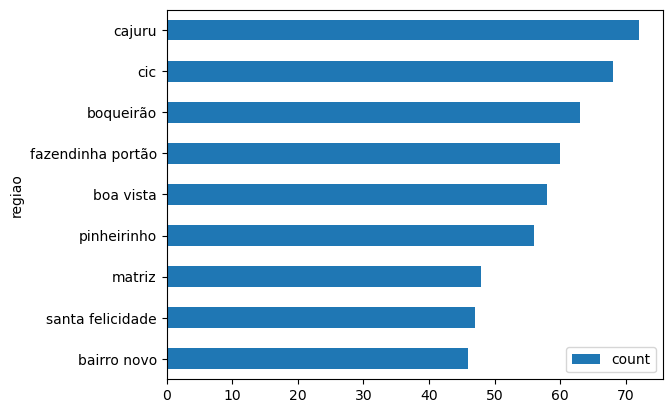

In [60]:
df_out_regiao = df_out_regiao.sort_values('count')
df_out_regiao.plot.barh(x='regiao')

### Análise por tipo de dia da semana

In [50]:
df_out_tipoDia = df_outliers.groupby('tipoDia').size().reset_index(name='count')
df_out_tipoDia = df_out_tipoDia.sort_values('count', ascending=False)
df_out_tipoDia

,tipoDia,count
0,dia útil,445
1,fim de semana,73


<AxesSubplot:ylabel='tipoDia'>

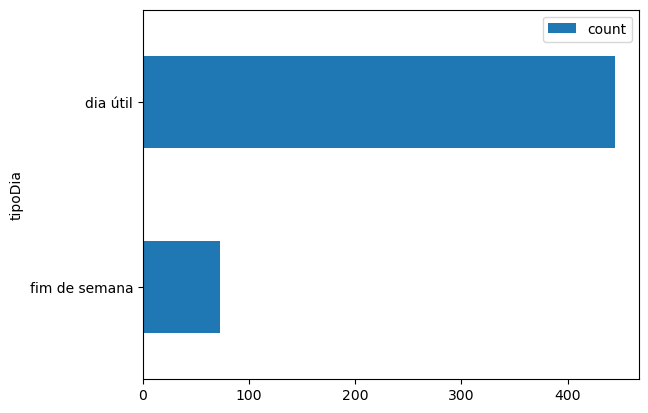

In [61]:
df_out_tipoDia = df_out_tipoDia.sort_values('count')
df_out_tipoDia.plot.barh(x='tipoDia')

### Análise por período do dia

In [51]:
df_out_periodoDia = df_outliers.groupby('periodoDia').size().reset_index(name='count')
df_out_periodoDia = df_out_periodoDia.sort_values('count', ascending=False)
df_out_periodoDia

,periodoDia,count
0,madrugada,322
2,noite,87
1,manhã,70
3,tarde,39


<AxesSubplot:ylabel='periodoDia'>

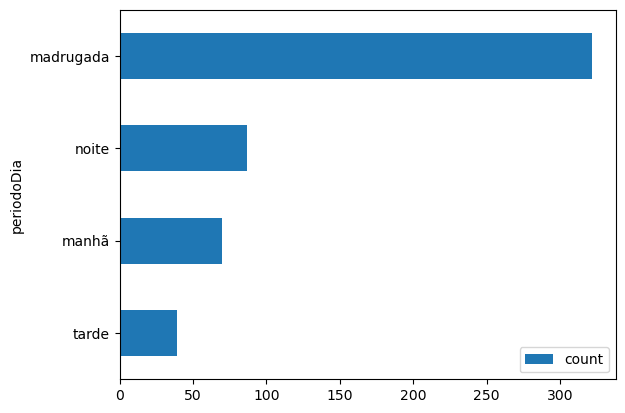

In [62]:
df_out_periodoDia = df_out_periodoDia.sort_values('count')
df_out_periodoDia.plot.barh(x='periodoDia')

### Alálise por tipo de ocorrência

In [52]:
df_out_ocorrencia = df_outliers.groupby('ocorrencia').size().reset_index(name='count')
df_out_ocorrencia = df_out_ocorrencia.sort_values('count', ascending=False)
df_out_ocorrencia

,ocorrencia,count
2,dano,127
0,agressão física/verbal,102
4,furto,88
7,porte ilegal,57
10,violação de medida protetiva lei maria da penha,50
1,crime ambiental,30
8,roubo,24
5,homicídio,16
3,estupro,13
9,seqüestro e cárcere privado,10


<AxesSubplot:ylabel='ocorrencia'>

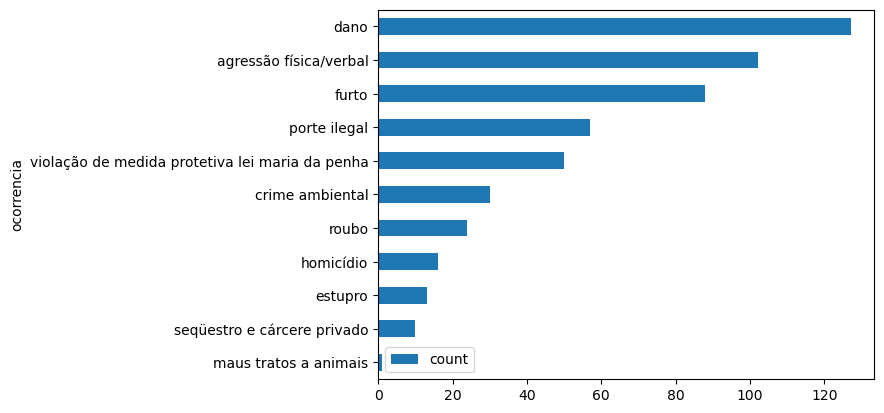

In [63]:
df_out_ocorrencia = df_out_ocorrencia.sort_values('count')
df_out_ocorrencia.plot.barh(x='ocorrencia')

### Análise por mês

In [53]:
df_out_mesNome = df_outliers.groupby('mesNome').size().reset_index(name='count')
df_out_mesNome = df_out_mesNome.sort_values('count', ascending=False)
df_out_mesNome

,mesNome,count
2,dezembro,80
1,agosto,66
4,janeiro,64
0,abril,62
5,julho,59
3,fevereiro,54
6,junho,37
7,maio,32
8,março,21
9,novembro,20


### Análise por ano

In [54]:
df_out_ano = df_outliers.groupby('ano').size().reset_index(name='count')
df_out_ano = df_out_ano.sort_values('count', ascending=False)
df_out_ano

,ano,count
0,2009,114
3,2012,70
5,2014,54
13,2022,52
1,2010,46
9,2018,37
4,2013,33
6,2015,27
10,2019,26
2,2011,21
